# 前期准备准备
## 公共变量定义

In [22]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:
save_it = True # On to save figures, off to show
save_type = '.png' #'.pdf' # '.pdf' or '.eps'

In [24]:
# 只使用默认模板，不是万不得已不要自己配色。不要对自己的审美过度自信，相信几十年百万人对设计师的相信。
dis_pal = "Set1" # 离散调色板，推荐使用matplotlib的cmap, scale_color/fill_cmap() 支持的调色板比较多
con_pal = "Reds" # 连续调色板
# 以下是nature顶刊的配色方案
# npg = ["#E64B35CC","#4DBBD5CC","#00A087CC", "#3C5488CC", "#F39B7FCC", "#8491B4CC", "#91D1c2CC","#DC0000CC", "#7E6148CC"]
npg = ["#b3e1cd","#f5b7bf","#fadbdf", "#a9d18e", "#a9e9e4"] #浅绿、淡红、浅红、草绿、淡蓝
aaas = ["#3B4992B2", "#EE0000B2", "#008B45B2", "#631879B2", "#008280B2", "#BB0021B2"]
# 取色网站：https://c.runoob.com/front-end/6214/#69c39c

In [25]:
# nature + ieee style theme
# plt.style.use(['nature','ieee'])
color = npg[0] # default one
# define colors iterator in CSS4_COLORS
import matplotlib as mpl
from itertools import cycle
# color_iter = cycle(mpl.colors.CSS4_COLORS.keys()) # 按CSS4颜色循环取色
color_iter = cycle(npg) # 按npg9种颜色循环取色

In [26]:
figs = '../figures/introduction/'
tabs = '../tabs/'
data_dir = 'datasets/'
xlabel = 'Days since last purchase'
ylabel = 'Frequency'
column_name = 'frequency'
title = 'Histogram of repurchase intervals\n with fitted distribution and its residuals'
# 检查子目录是否存在，不存在就创建
import os
def check_and_make_directories(directories: list[str]):
    print(f"Checking directories {directories}")
    for directory in directories:
        if not os.path.exists("./" + directory):
            os.makedirs("./" + directory)
        else:
            print(f"Directory `{directory}` already exist")

# check_and_make_directories(figs)

## 用于拟合

In [27]:
from importlib import import_module
def x_y_residuals_freq(samples, tuner=(1, 1, 2, 100000)):
    ''' An adaptive version using best_fit() to get the best pdf for samples.
    returns x-axis, theoretical pdf y, the residuals = samples' frequency - y, and the samples' frequency
    :param @tuner {a:1, loc:1, scale:1} tune the params 
    '''
    name, params = best_fit(samples)
    print(name,params)
    model = getattr(import_module('scipy.stats'), name)
    # sf: samples' freqency, for histogram plotting
    sf = pd.value_counts(samples).sort_index()  # pd.Series
    sf = sf[3:] # 前面的几个总是太大
    x = sf.index
    # y = model.pdf(x,**params) * 50000 # 这里估计要手工调       # pdf
    y = model.pdf(x, a=params['a']*tuner[0], loc=params['loc']*tuner[1], scale=params['scale']*tuner[2]) * tuner[3] # 这里估计要手工调       # pdf
    residuals = sf - y   # samples的频度曲线与理论曲线想减
    sf = pd.DataFrame(sf, columns=['count'])
    return x, y, residuals, sf

from scipy.stats import gamma
from fitter import Fitter
def best_fit(samples, distributions=['gamma','powerlaw']):
    ''' try to find the best fit for samples
    :param samples: array of samples, assert len(samples) > 1 & type(samples) in [pd.Series, np.array, list]
    :param distributions: list of distributions, default is ['gamma','normal','powerlaw']
    :return {'gamma': {'a': 0.8758464218570574, 'loc': 0.9999999999999998, 'scale': 32.73875322801199}}
    '''
    f = Fitter(samples, distributions=distributions, timeout=30, density=True)
    f.fit()
    f.summary()
    name = list(f.get_best().keys())[0] # a str
    params = list(f.get_best().values())[0] # a dict
    return name, params


def gamma_fit(samples):
    '''specialized for gamma fitting'''
    fit = gamma.fit(samples)
    sf = pd.DataFrame(samples).value_counts().sort_index().values
    x = np.arange(0, len(sf), 1) 
    y = gamma.pdf(x,a=fit[0]*1, loc=fit[1]-15, scale=fit[2]) * 80000    
    residuals = sf - y
    sf = pd.DataFrame(sf, columns=['frequency'])
    return x, y, residuals, sf



## 定义绘图函数
- 增加Buy_dis_plot2() 参数与Buy_dis_plot()完全一样，方便直接替换
- 增加Buy_dis_plot3() 参数完全一样

In [28]:
from plotnine import *
from plotnine_prism import *
def Buy_dis_plot2(data_buygap_tafeng,colume_name,ylabel,xlabel,title,xlim=False,ylim=False, filename=None):
    now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    df_buygap_tafeng = pd.DataFrame(data_buygap_tafeng,columns=[colume_name])
    c = next(color_iter)    # 不然的话，color算一次，fill算一次
    p = (
        ggplot(df_buygap_tafeng, aes(x=colume_name))
        + geom_histogram(bins=100, color=c, fill=c)
        + xlab(xlabel)
        # + stat_density(aes(y=after_stat('count')), alpha=1)
        + theme_prism()
    )
    p.save(figs+filename+"."+now+save_type) if filename is not None else print(p)
    return p

def Buy_dis_plot3(samples,column_name,ylabel,xlabel,title,xlim=False,ylim=False, tuner=(1,1,2,100000),filename=None):
    # x,y,resi,s_freq = gamma_fit(samples)
    x,y,resi, s_freq = x_y_residuals_freq(samples, tuner=tuner)
    return plot4(s_freq, y, resi, xlabel, ylabel, title, filename)

def plot4(s_freq, y, resi, xlabel, ylabel, title, filename = None):
    c = next(color_iter)    # 不然的话，color算一次，fill算一次
    p = (
        ggplot(s_freq, aes(x=s_freq.index))
        + geom_col(mapping=aes(y=s_freq.values.squeeze()),fill=c, alpha=1)
        + geom_line(mapping=aes(y=y), color='k',size=1, alpha=1)
        + geom_col(mapping=aes(y=-resi),fill=c, alpha=.5)
        # + geom_smooth(mapping=aes(y=-resi), color="k", alpha=0.5, span=.1, se=False)
        + geom_path(mapping=aes(y=-resi), color="k", alpha=1,linetype="dashdot")
        + annotate('text', x=len(resi)/1.1, y=resi.max()/1.5, label='fitted major distribution \n(black line)',  size=15, color='k', ha='right')
        + annotate('text', x=len(resi)/1.1, y=-resi.max()/2, label='residuals (mirrored)',  size=15, color="k", ha='right')
        + labs(x=xlabel,y= ylabel)
        # + ggtitle(title+"\nInstacart dataset")
        + theme_prism()
    )
    if save_it and filename is not None:
        now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        p.save(figs+filename+save_type, dpi=600)
    return p

# Instacart数据集

In [29]:
instacart = pd.read_csv(data_dir+"instacart.csv")[column_name].to_list()

In [30]:
samples = instacart
name = "gamma"
# from scipy.stats import chi2 as model
from importlib import import_module
model = getattr(import_module('scipy.stats'), name)
# params=model.fit(instacart)
# params

<Axes: >

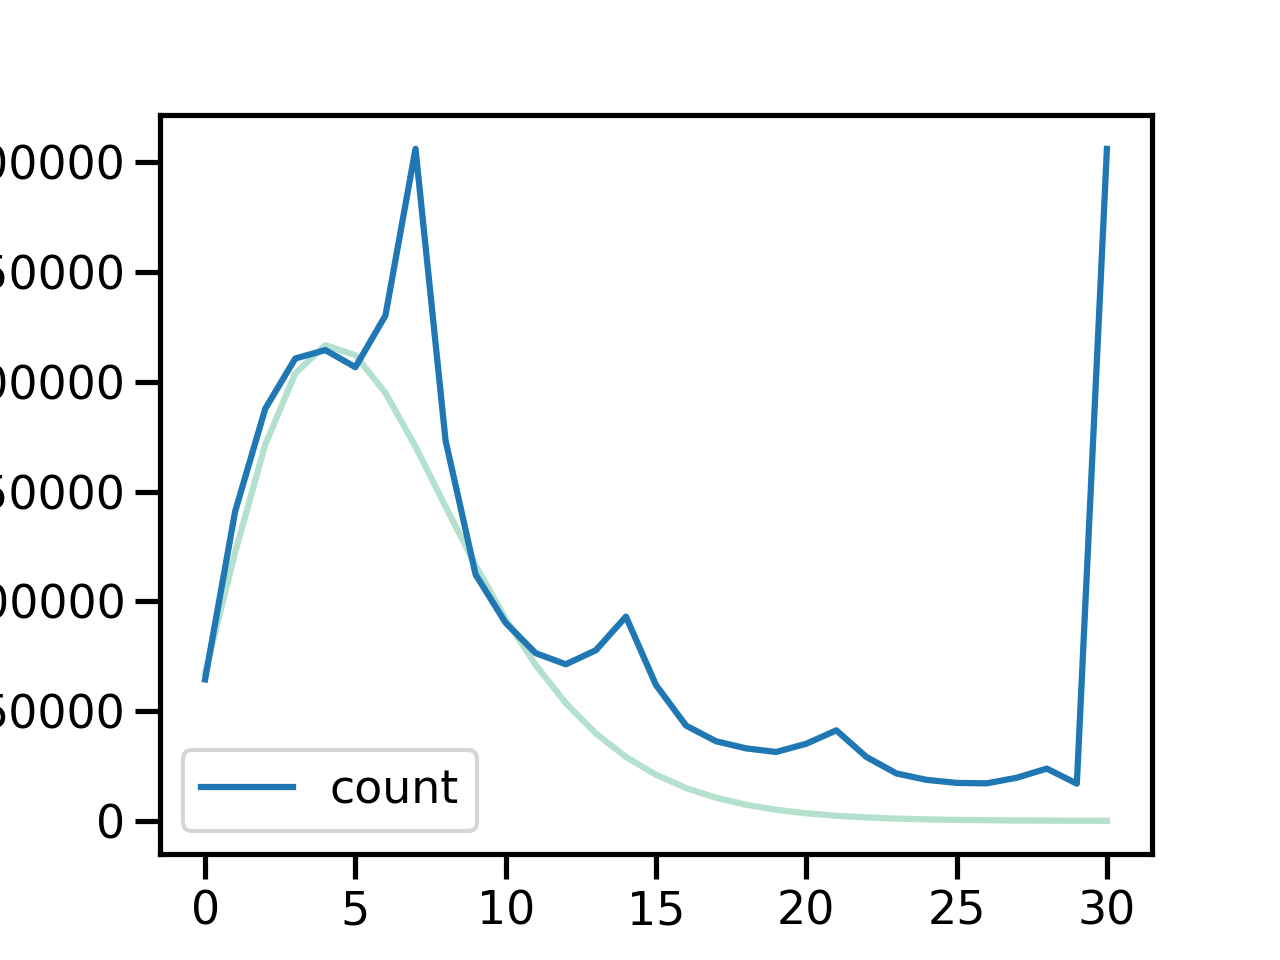

In [31]:
samples = pd.Series(samples)
# tuner = (3.6496,30,0.25,400000)
# sf: samples' freqency, for histogram plotting
sf = pd.value_counts(samples).sort_index()  # pd.Series
# sf = sf[3:] # 前面的几个总是太大
x = sf.index
# y = model.pdf(x, params[0]*tuner[0], params[1]*tuner[1], params[2]*tuner[2]) * tuner[3] # 这里估计要手工调       # pdf
y = model.pdf(x, 5, -3, 1.8) * 2000000 # 这里估计要手工调       # pdf
resi = sf - y   # samples的频度曲线与理论曲线想减
sf = pd.DataFrame(sf, columns=['count'])
# x, y, residuals, sf
sns.set_context('talk')
sns.lineplot(y, color=npg[0])
sns.lineplot(sf, color=npg[1])
# sns.histplot(samples)

/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/introduction/instacart.png


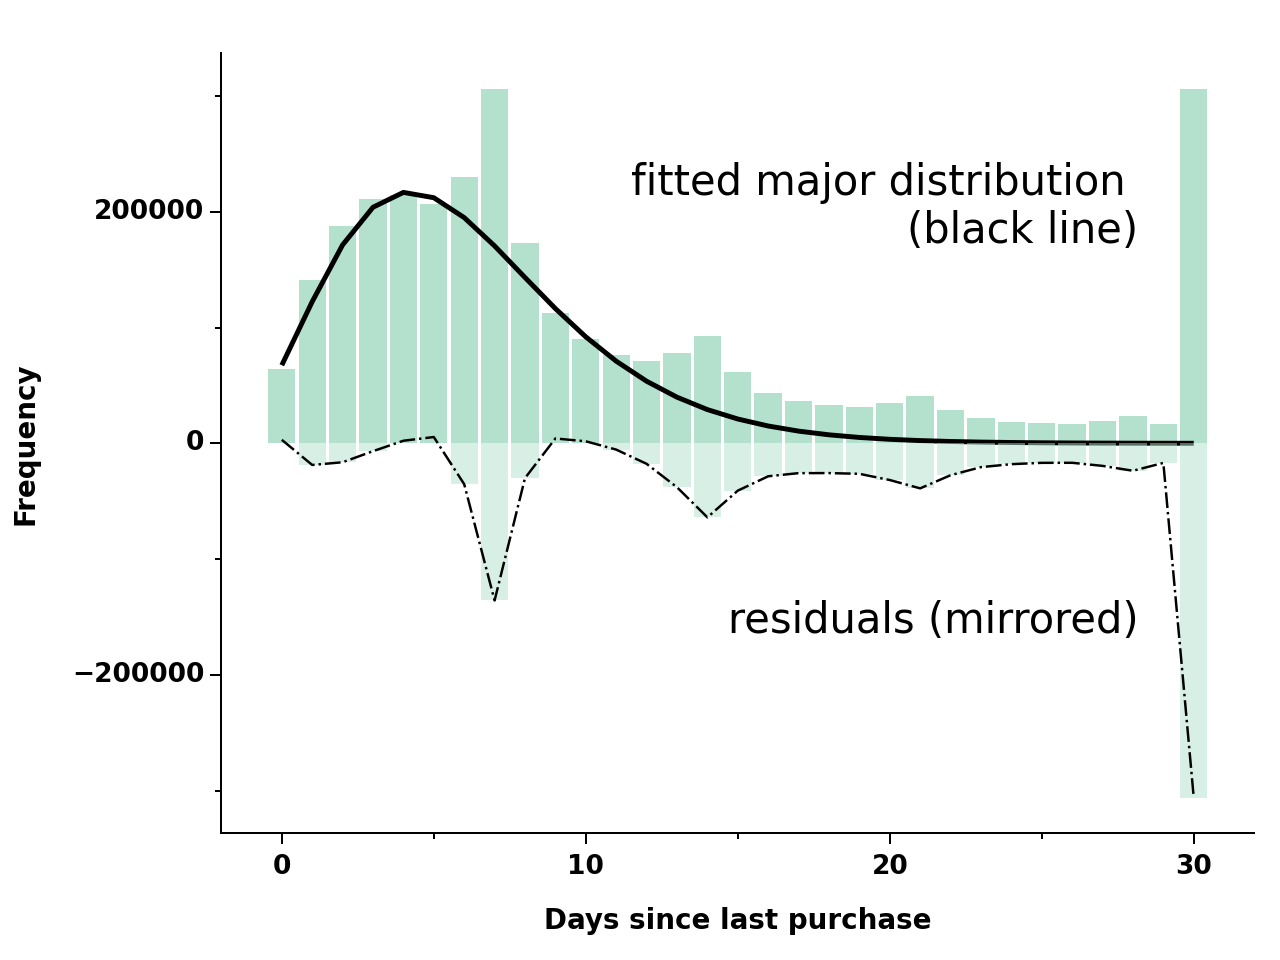

<Figure Size: (640 x 480)>

In [32]:

plot4(sf, y, resi, xlabel, ylabel, title, filename="instacart")


# tafeng 数据集

## Tafeng数据集的整体观察

from
- https://github.com/laidasani/Finding-Frequent-Itemset/blob/master/DataSet/ta_feng_all_months_merged.csv
- https://www.kaggle.com/datasets/chiranjivdas09/ta-feng-grocery-dataset

In [33]:
tafeng = pd.read_csv(data_dir+"tafeng.csv")[column_name].to_list()

2024-04-24 16:11:06.457 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.006875)
2024-04-24 16:11:06.905 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.003428)
/var/folders/5z/7l96pnn14y9_hv9w5nnbtxs00000gn/T/ipykernel_807/2538927694.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/introduction/tafeng.png


gamma {'a': 0.8758464218570574, 'loc': 0.9999999999999998, 'scale': 32.73875322801199}


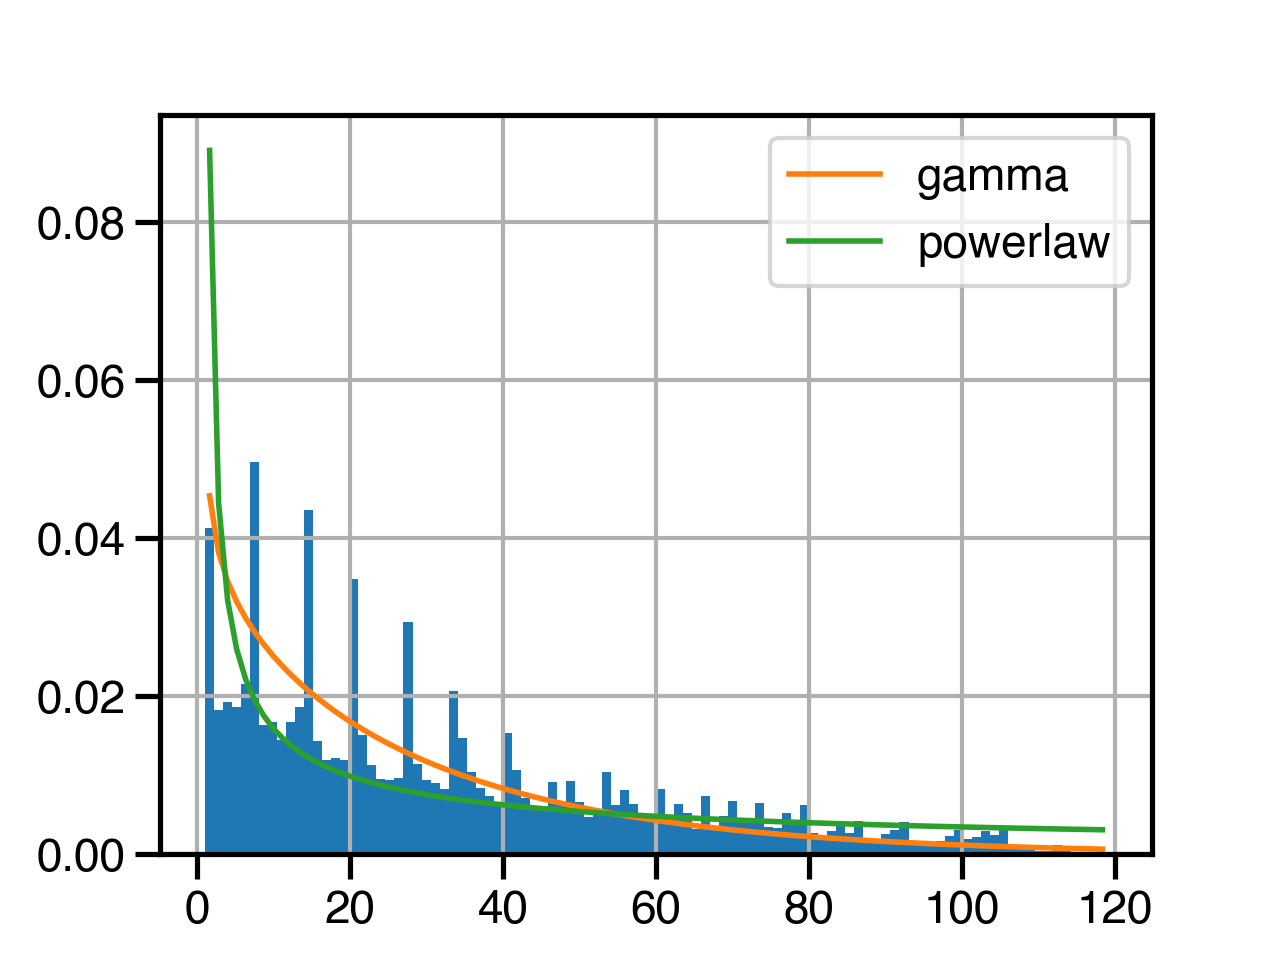

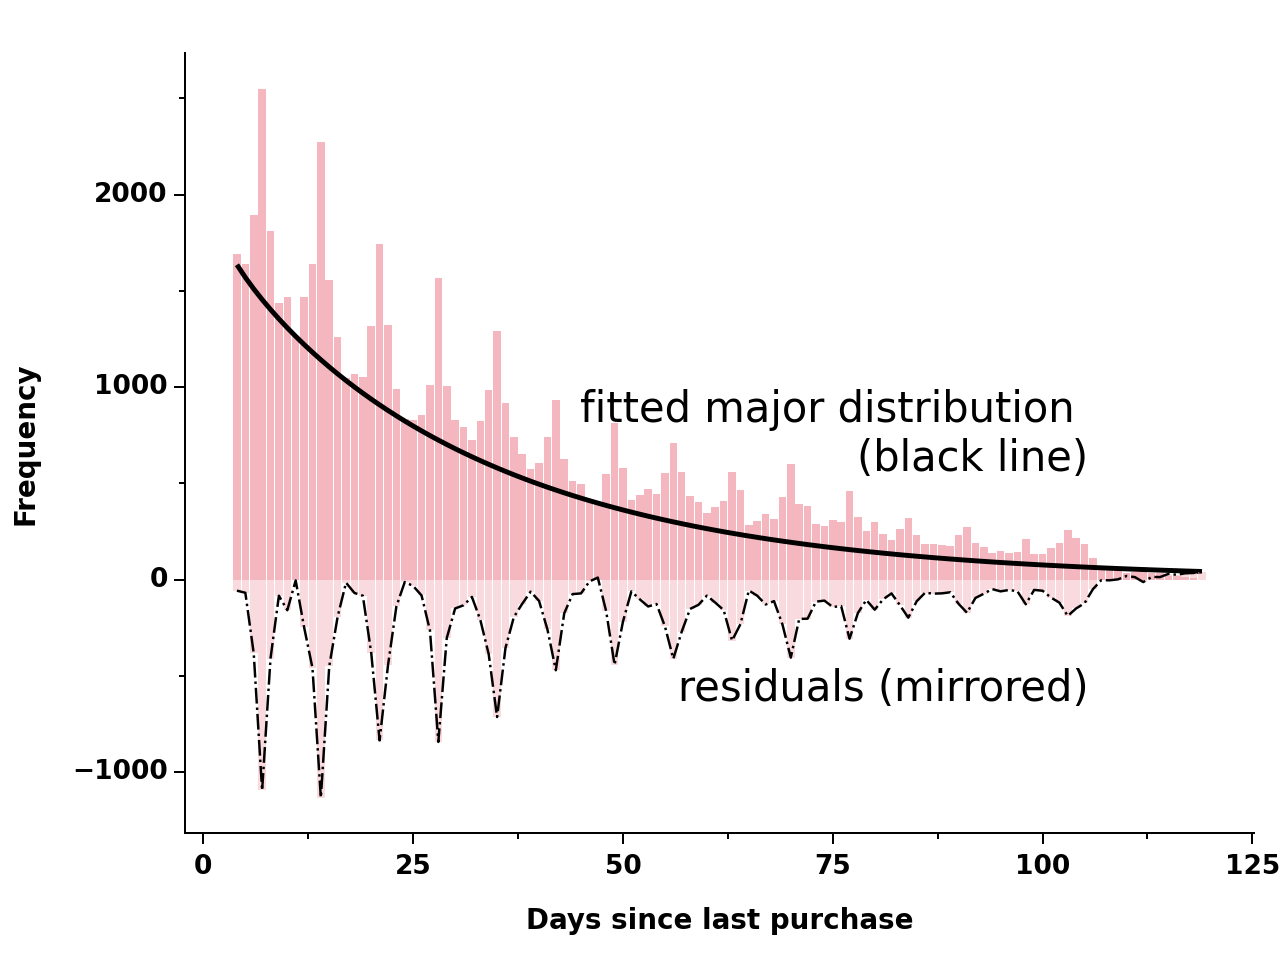

<Figure Size: (640 x 480)>

In [34]:
Buy_dis_plot3(tafeng, 
              column_name=column_name, 
              ylabel=ylabel, 
              xlabel=xlabel, 
              title=title+"\nTafeng dataset", 
              xlim=False, 
              ylim=False,
              tuner=(1.1,1,1,55000),
              filename = "tafeng"
              )

# Taobao 数据集

from 
- UserBehavior.csv https://tianchi.aliyun.com/dataset/649 
- IJCAI2016 https://github.com/jiangsirspider/2021recommend_algorism/blob/master/ijcai2016_taobao.csv

In [35]:
taobao = pd.read_csv(data_dir+'taobao.csv')[column_name].to_list()

## 整体观察

2024-04-24 16:11:08.790 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.003689)
2024-04-24 16:11:11.555 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.001663)
/var/folders/5z/7l96pnn14y9_hv9w5nnbtxs00000gn/T/ipykernel_807/2538927694.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/introduction/tabao.png


gamma {'a': 0.5690592834963472, 'loc': 0.9999999999999998, 'scale': 28.98679388659643}


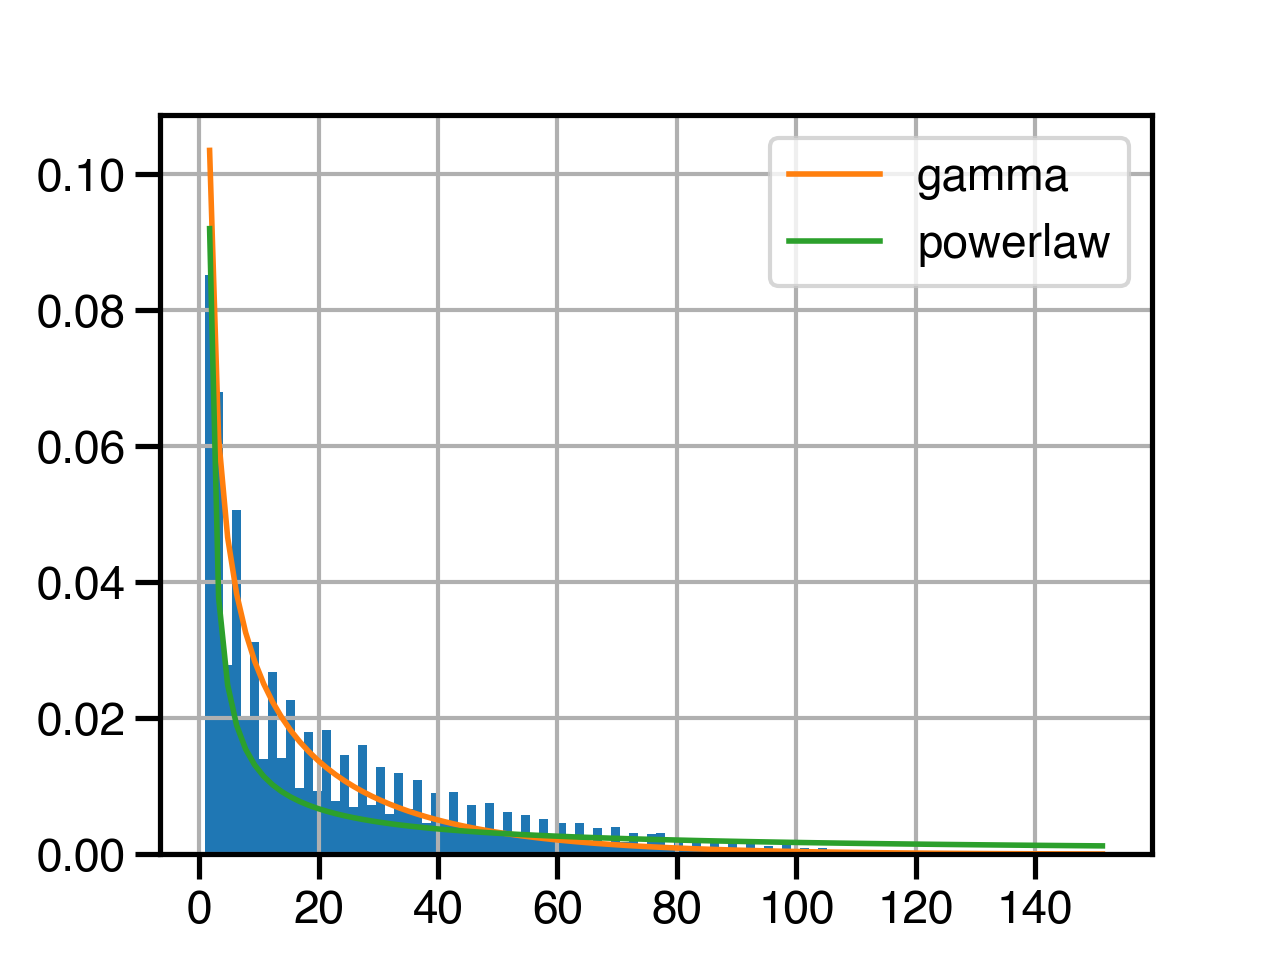

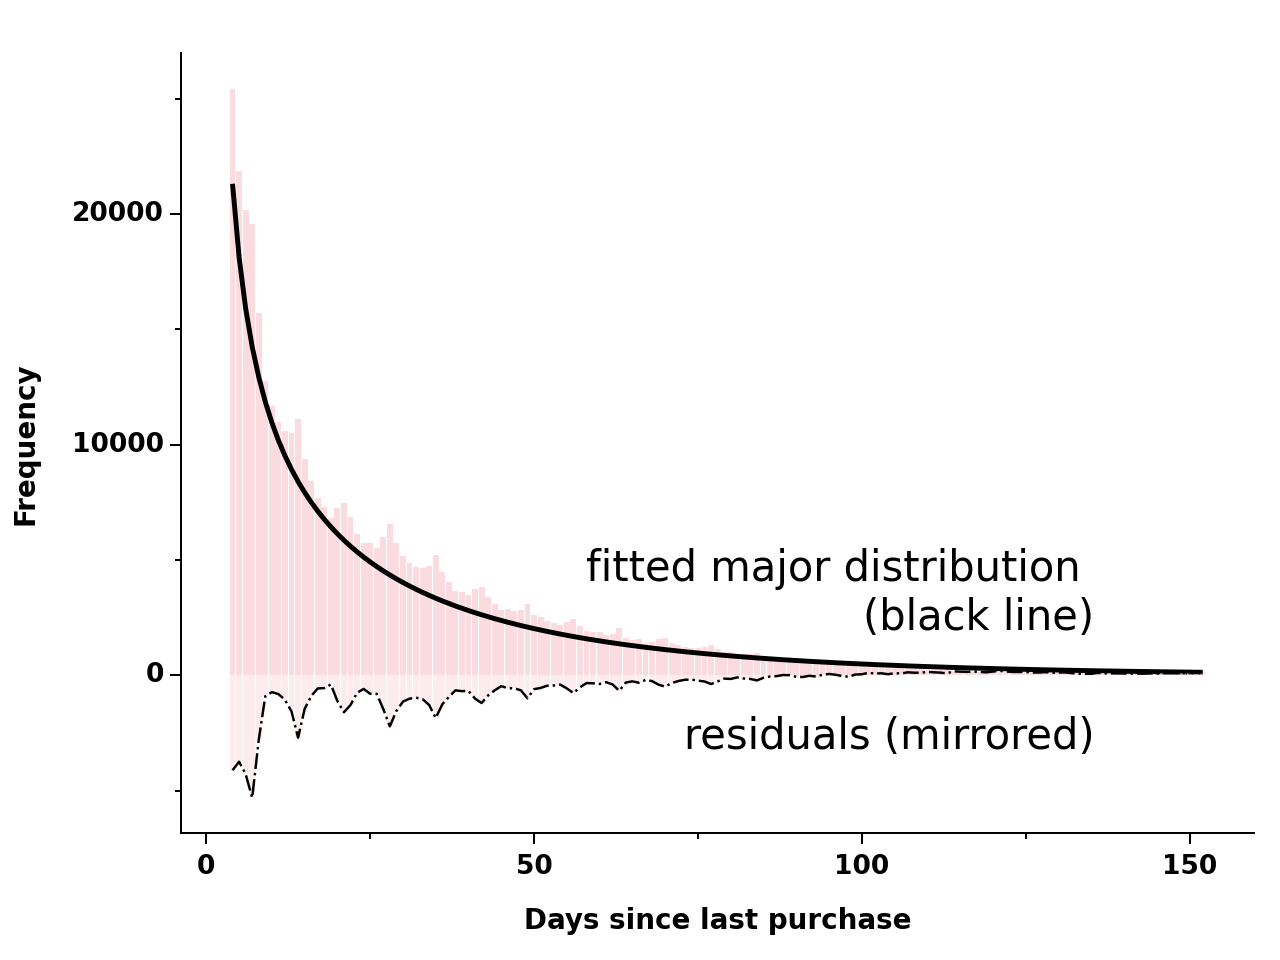

<Figure Size: (640 x 480)>

In [36]:
Buy_dis_plot3(taobao, 
              column_name=column_name, 
              ylabel=ylabel, 
              xlabel=xlabel, 
              title=title+"\nTabao dataset", 
              xlim=False, 
              ylim=False,
              tuner=(0.9,1,1.6,480000),
              filename = "tabao"
              )

# Tianmao

In [37]:
s_tm = pd.read_csv(data_dir+'tianmao.csv')
tianmao = list(s_tm[column_name])

## Tianmao整体观察

2024-04-24 16:11:13.066 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.004938)
2024-04-24 16:11:13.461 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.002251)
/var/folders/5z/7l96pnn14y9_hv9w5nnbtxs00000gn/T/ipykernel_807/2538927694.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/introduction/tianmao.png


gamma {'a': 0.43015180206495596, 'loc': 0.9999999999999999, 'scale': 39.442964948914664}


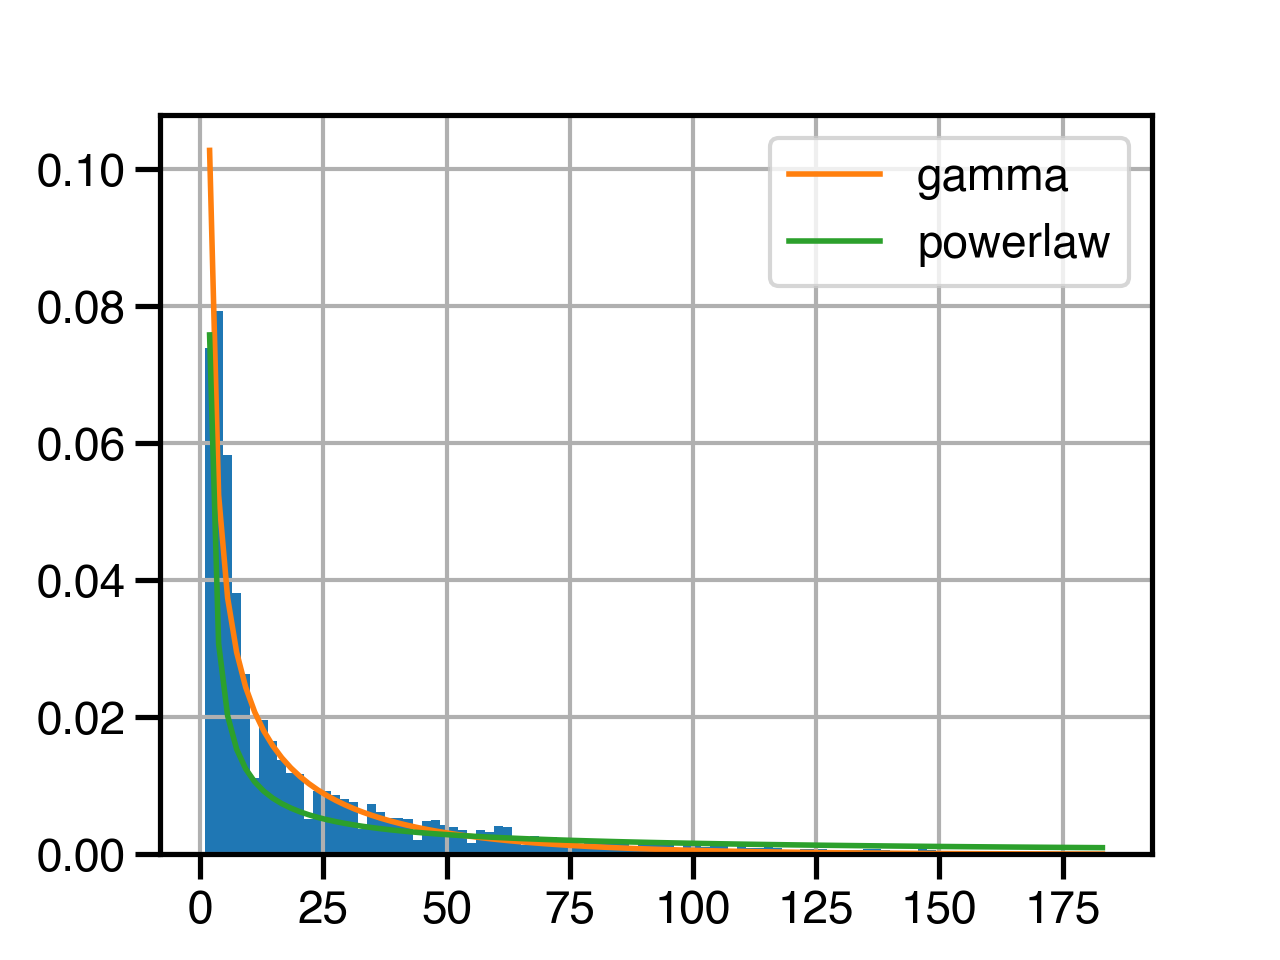

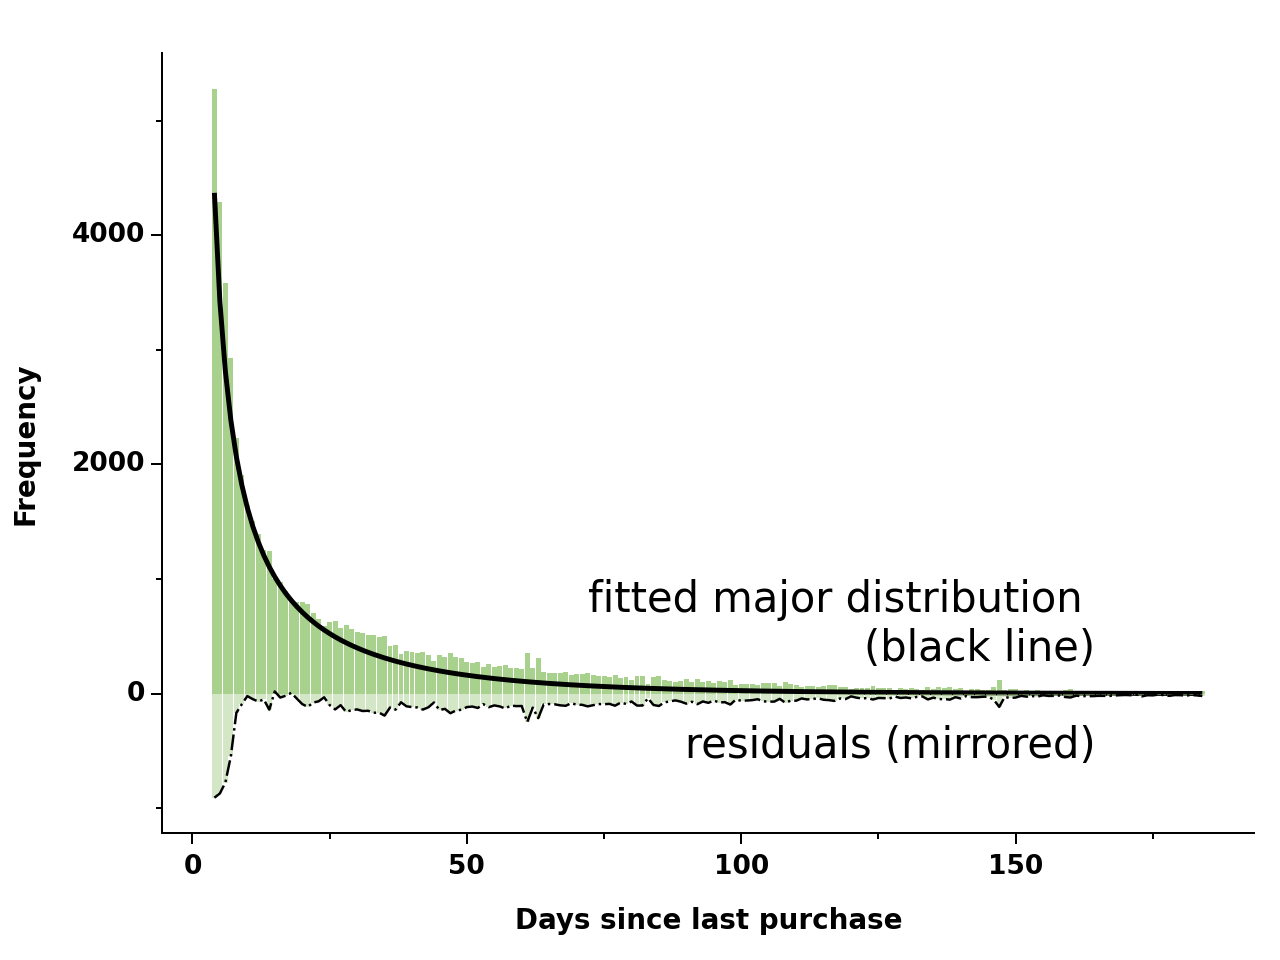

<Figure Size: (640 x 480)>

In [38]:
Buy_dis_plot3(tianmao, 
              column_name=column_name, 
              ylabel=ylabel, 
              xlabel=xlabel, 
              title=title+"\nTabao dataset", 
              xlim=False, 
              ylim=False,
              tuner=(0.55,1,1,100000),
              filename = "tianmao"
              )

# Equity dataset

In [39]:
equity = pd.read_csv(data_dir+"equity.csv")[column_name].to_list()

In [40]:
samples = equity
name = "t"
# from scipy.stats import chi2 as model
from importlib import import_module
model = getattr(import_module('scipy.stats'), name)
# params=model.fit(samples)
# params

In [41]:
samples = pd.Series(samples)
# tuner = (3.6496,30,0.25,400000)
# sf: samples' frequency, for histogram plotting
sf = pd.value_counts(samples).sort_index()  # pd.Series
# sf = sf[3:] # 前面的几个总是太大
x = sf.index
# y = model.pdf(x, params[0]*tuner[0], params[1]*tuner[1], params[2]*tuner[2]) * tuner[3] # 这里估计要手工调       # pdf
y = model.pdf(x, 1, 30.5, 1.2) * 18000   # 这里估计要手工调       # pdf
resi = sf - y   # samples的频度曲线与理论曲线相减

/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/yin/miniconda3/envs/rtb/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/introduction/equity.png


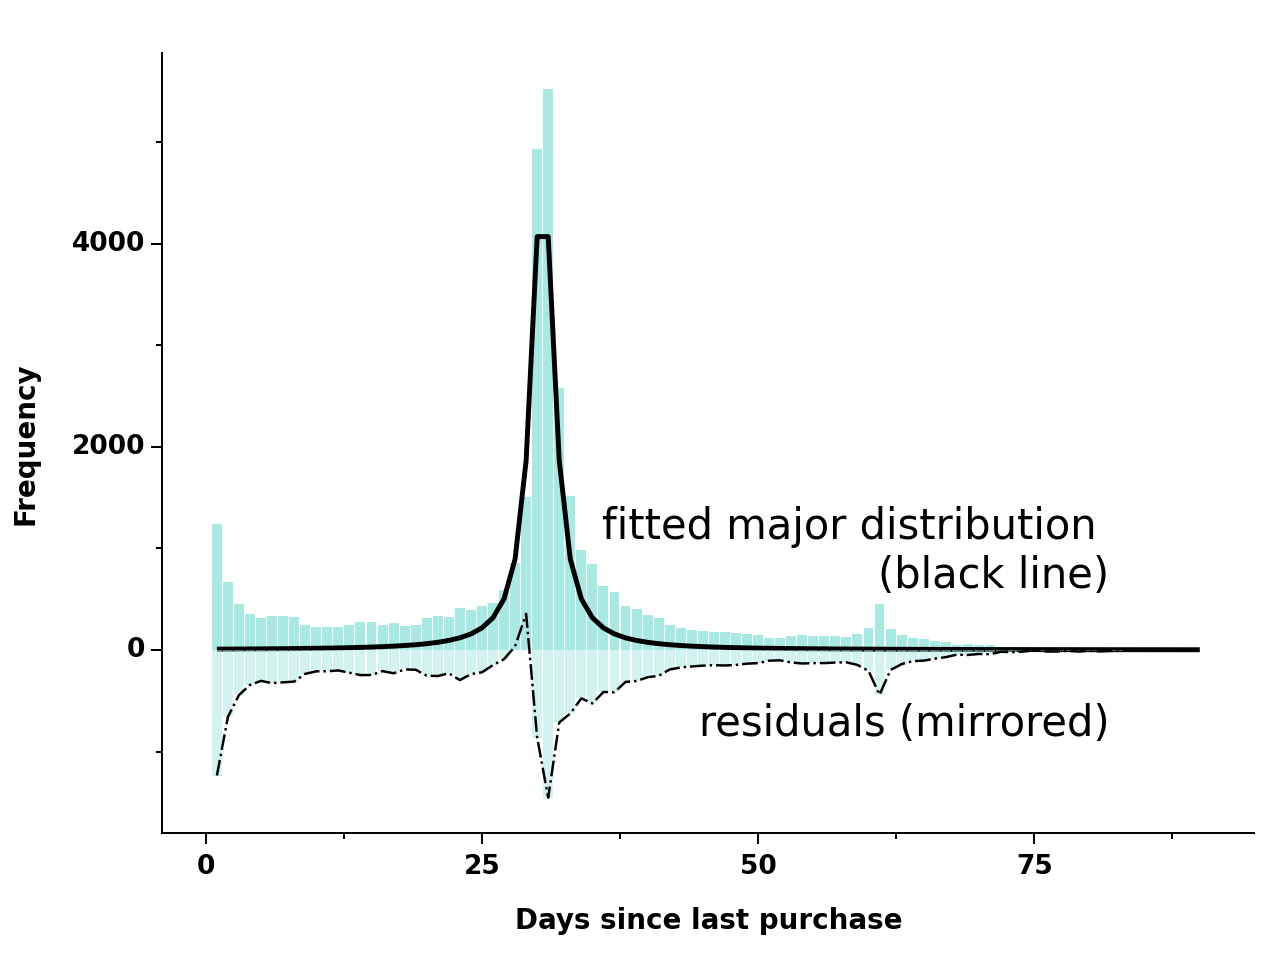

<Figure Size: (640 x 480)>

In [42]:
s_freq = sf.to_frame(name=column_name)  # pd.DataFrame(sf, columns=[column_name])
plot4(s_freq,y,resi,xlabel, ylabel, title, filename="equity")
